# Resume Extraction Project

This project takes open data of resumes written by many candidates and extracts informations.

In [1]:


with open(r'data/new_resumes.json', encoding='utf8') as f:
    
    data_file= f.read()
 



## Approach

The approach here is to take as target the highlighted information under the "text" part for each instance. 


Below is the data cleaning process to extract this information using the regular expressions library.


In [2]:
import re
import pandas as pd

new_data = data_file.split('}]}]}')
informations_candidates = []

for data in new_data:
    #information = re.findall(r'"text":([^\"])"}',data)
    data = data.replace(r'\n', ' ')
    data = data.replace('-', ' ')
    data = data.replace(r'/', ' ')
    information = re.findall(r'"text":"([^"]+)"}',data)
    # A set is taken to avoid repetition
    to_append = list(set(information))
    if len(to_append)==0:
        informations_candidates.append(pd.NA)
    else:        
        informations_candidates.append(to_append)



In [3]:


df = pd.DataFrame({'Text': new_data, 'Information extracted': informations_candidates})


In [4]:
df.iloc[1,1]

['Manual and Automation testing.',
 'B.Sc. in Computer Science',
 'Functional Testing, Blue Prism, Qtp ',
 'Hyderabad',
 '6 Yrs',
 'MCA',
 'Test Analyst',
 ' Osmania University ',
 'QA Analyst']

In [5]:
from sentence_transformers import SentenceTransformer

c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [18]:
df.iloc[0,0]

'{"content": "Govardhana K\\nSenior Software Engineer\\n\\nBengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/\\nb2de315d95905b68\\n\\nTotal IT experience 5 Years 6 Months\\nCloud Lending Solutions INC 4 Month • Salesforce Developer\\n 5 Years 2 Month • Core Java Developer\\nLanguages Core Java, Go Lang\\n PL-SQL programming,\\nSales Force Developer with APEX.\\n\\nDesignations & Promotions\\n\\nWilling to relocate: Anywhere\\n\\nWORK EXPERIENCE\\n\\nSenior Software Engineer\\n\\nCloud Lending Solutions -  Bangalore, Karnataka -\\n\\nJanuary 2018 to Present\\n\\nPresent\\n\\nSenior Consultant\\n\\n -  Bangalore, Karnataka -\\n\\nNovember 2016 to December 2017\\n\\nStaff Consultant\\n\\n -  Bangalore, Karnataka -\\n\\nJanuary 2014 to October 2016\\n\\nAssociate Consultant\\n\\n -  Bangalore, Karnataka -\\n\\nNovember 2012 to December 2013\\n\\nEDUCATION\\n\\nB.E in Computer Science Engineering\\n\\nAdithya Institute of Technology -  Tamil Nadu\\n\\nSeptember

In [17]:
train_data.to_numpy()

array([[('Languages: Core Java, Go Lang, Data Structures & Algorithms,  PL SQL programming, Sales Force with APEX. Tools: RADTool, Jdeveloper, NetBeans, Eclipse, SQL developer, PL SQL Developer, WinSCP, Putty Web Technologies: JavaScript, XML, HTML, Webservice  Operating Systems: Linux, Windows Version control system SVN & Git Hub Databases:  Middleware: Web logic, OC4J Product FLEXCUBE:  FLEXCUBE Versions 10.x, 11.x and 12.x', 'consultant'),
        1.0],
       [('Senior Consultant ', 'year'), 1.0],
       [('Bengaluru', 'experience'), 1.0],
       [('Associate Consultant', 'consultant'), 1.0],
       [('2012', 'consultant'), 1.0],
       [('indeed.com r Govardhana K  b2de315d95905b68 ', 'website link'),
        1.0],
       [('Adithya Institute of Technology', 'cloud'), 1.0],
       [('B.E in Computer Science Engineering', 'engineer'), 1.0],
       [('Senior Software Engineer ', 'location'), 1.0],
       [('APEX. (Less than 1 year), Data Structures (3 years), FLEXCUBE (5 years),  (5

In [30]:
model.parameters

<bound method Module.parameters of SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)>

In [ ]:
m

In [29]:
import inspect

inspect.getmembers(model, lambda a: not(inspect.isroutine(a)))

`SentenceTransformer._target_device` has been deprecated, please use `SentenceTransformer.device` instead.


[('T_destination', ~T_destination),
 ('__annotations__',
  {'_modules': typing.Dict[str, torch.nn.modules.module.Module]}),
 ('__class__', sentence_transformers.SentenceTransformer.SentenceTransformer),
 ('__dict__',
  {'prompts': {},
   'default_prompt_name': None,
   '_similarity_fn_name': 'cosine',
   'truncate_dim': None,
   'model_card_data': SentenceTransformerModelCardData(language=[], license=None, model_name=None, model_id=None, train_datasets=[{'size': 21, 'columns': ['<code>Texts1</code>', '<code>Texts2</code>', '<code>Labels</code>'], 'stats': {'Texts1': {'dtype': 'string', 'data': {'min': '3 tokens', 'mean': '12.86 tokens', 'max': '114 tokens'}}, 'Texts2': {'dtype': 'string', 'data': {'min': '3 tokens', 'mean': '3.19 tokens', 'max': '4 tokens'}}, 'Labels': {'dtype': 'float', 'data': {'min': 1.0, 'mean': 1.0, 'max': 1.0}}}, 'stats_table': '  |         | Texts1                                                                             | Texts2                               

In [38]:
train.features


{'Texts1': Value(dtype='string', id=None),
 'Texts2': Value(dtype='string', id=None),
 'Labels': Value(dtype='float64', id=None)}

In [20]:
l

[['Senior Software Engineer ', 'consultant'],
 ['2012', 'year'],
 ['APEX. (Less than 1 year), Data Structures (3 years), FLEXCUBE (5 years),  (5 years), Algorithms (3 years) ',
  'experience'],
 ['Cloud Lending Solutions', 'consultant'],
 ['Languages: Core Java, Go Lang, Data Structures & Algorithms,  PL SQL programming, Sales Force with APEX. Tools: RADTool, Jdeveloper, NetBeans, Eclipse, SQL developer, PL SQL Developer, WinSCP, Putty Web Technologies: JavaScript, XML, HTML, Webservice  Operating Systems: Linux, Windows Version control system SVN & Git Hub Databases:  Middleware: Web logic, OC4J Product FLEXCUBE:  FLEXCUBE Versions 10.x, 11.x and 12.x',
  'consultant'],
 ['indeed.com r Govardhana K  b2de315d95905b68 ', 'website link'],
 ['Bengaluru', 'cloud'],
 ['Staff Consultant', 'engineer'],
 ['Senior Consultant ', 'location'],
 ['B.E in Computer Science Engineering', 'programming languages'],
 ['Associate Consultant', 'university degree'],
 ['Adithya Institute of Technology', 'uni

# EDA 

We are performing exploratory data analysis (EDA) on the data. Below is some statistical analysis of the distribution of word lenghts and character lenghts.



In [7]:
print(f"There are initially {sum(df.iloc[:,1].isna())} NA in the dataset.")

df = df.dropna()

print(f"There are now {sum(df.iloc[:,1].isna())} NA in the dataset after dropping them.")

There are initially 1 NA in the dataset.
There are now 0 NA in the dataset after dropping them.


Text(13.819444444444445, 0.5, 'number of samples with this average character number')

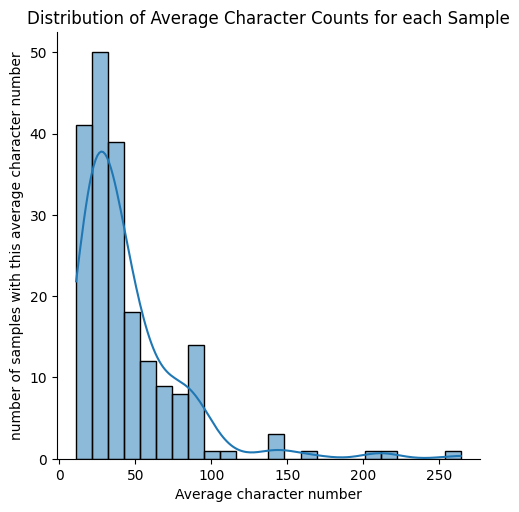

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

char_count = df.iloc[:,1].map(lambda x: sum([len(i) for i in x])/len(x))

sns.displot(char_count, kde = True)
plt.title("Distribution of Average Character Counts for each Sample")

plt.xlabel('Average character number')
plt.ylabel('number of samples with this average character number')

Text(13.819444444444445, 0.5, 'number of samples with this average number of words')

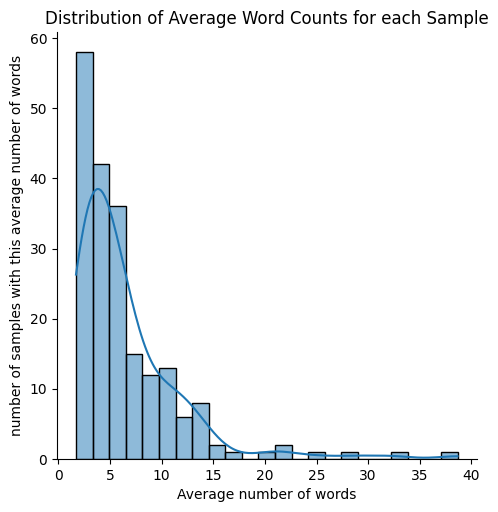

In [57]:
word_count = df.iloc[:,1].map(lambda x: sum([len(i.split()) for i in x])/len(x))

sns.displot(word_count, kde = True)

plt.title("Distribution of Average Word Counts for each Sample")

plt.xlabel('Average number of words')
plt.ylabel('number of samples with this average number of words')


#### Semantic Similarity 

We are now visualizing the proximity of semantically similar words.

In [16]:

from sentence_transformers import  SentenceTransformer

c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text(0, 0.5, 'Value of the 3rd dimension in the vector space')

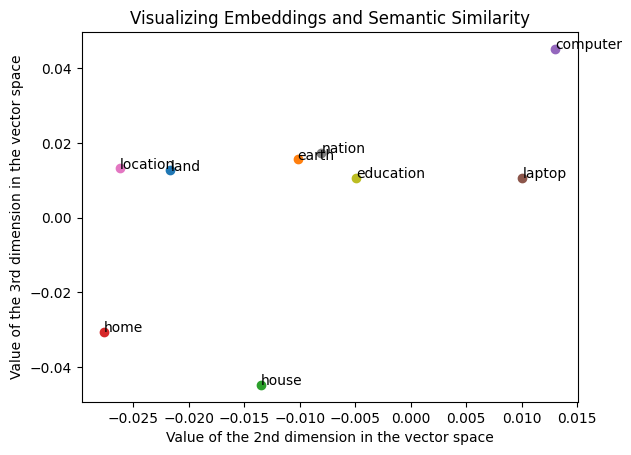

In [42]:
import matplotlib.pyplot as plt
import numpy as np

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

list_of_words = ["land", "earth", "house", "home", "computer", "laptop", "location", "nation", 'education']

vectors = [model.encode(i) for i in list_of_words]

vectors = np.array(vectors)

for v in range(len(vectors)):
   
   plt.scatter(vectors[v][2], vectors[v][3])
   plt.annotate(list_of_words[v], xy= (vectors[v][2], vectors[v][3]))

plt.title("Visualizing Embeddings and Semantic Similarity")

plt.xlabel("Value of the 2nd dimension in the vector space")
plt.ylabel("Value of the 3rd dimension in the vector space")

     




Text(0.5, 1.0, 'Embedding Similarity Heatmap')

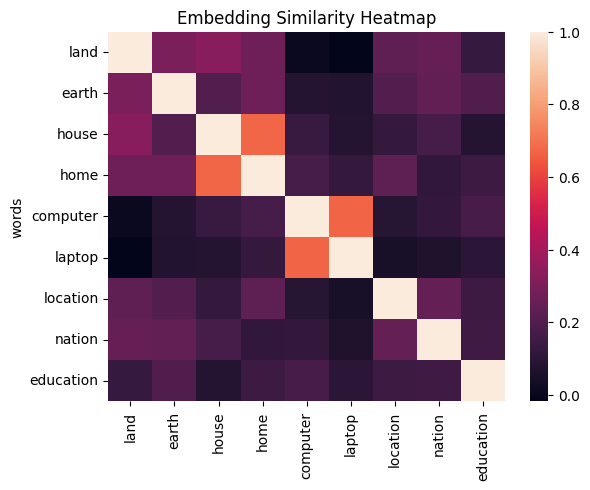

In [58]:
import seaborn as sns
import pandas as pd

d = pd.DataFrame(np.array(vectors)@np.array(vectors).T, columns= list_of_words)
d['words'] = list_of_words
d = d.set_index('words')
sns.heatmap(d)
plt.title('Embedding Similarity Heatmap')

## Modeling technique

Using a triplet loss is solution. This involves training a model with data points considered "positive", others considered "negative" and an anchor (the actual sample). The goal is to train the model to get answers for a given anchor close to its label (positive or negative). 

Another approach, which is the one adopted here, is to work on maximizing the similarity score (cosine similarity score) between the embeddings of the relevant parts to extract in the sample and the corresponding words we took as positive. These parts are the relevant ones after splitting the text according to new lines, as it follows a logic pattern here. The words more similar than a threshold value in similarity matrix are then extracted. We use the sentence transformers library which has ready embeddings, although they can be fine tuned for our use case.

c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text(0, 0.5, 'Value of the 3rd dimension in the vector space')

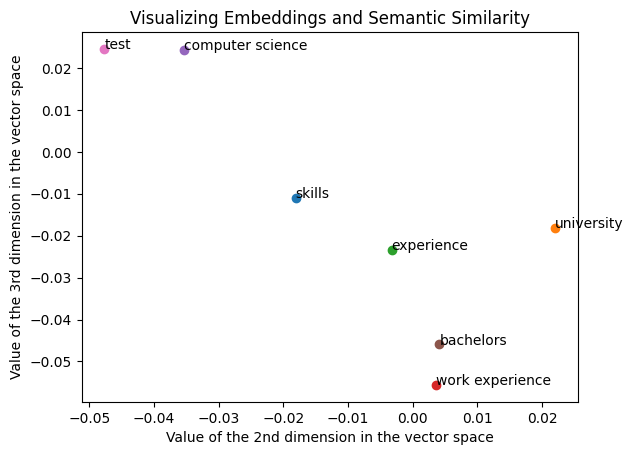

In [19]:
import matplotlib.pyplot as plt
import numpy as np

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

list_of_words = ["skills", "university", "experience", "work experience", "computer science", "bachelors", "test"]

vectors = [model.encode(i) for i in list_of_words]

vectors = np.array(vectors)

for v in range(len(vectors)):
   
   plt.scatter(vectors[v][2], vectors[v][3])
   plt.annotate(list_of_words[v], xy= (vectors[v][2], vectors[v][3]))

plt.title("Visualizing Embeddings and Semantic Similarity")

plt.xlabel("Value of the 2nd dimension in the vector space")
plt.ylabel("Value of the 3rd dimension in the vector space")

     




In [42]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

a = model.encode("istanbul technical university")
b = model.encode("university")

print(f"""The output of the similarity function of the model: {model.similarity(a,b)[0][0]}; 
is the same as the dot product (inner product) of the embedding vectors: {a@b}""")

The output of the similarity function of the model: 0.4779433012008667; 
is the same as the dot product (inner product) of the embedding vectors: 0.4779433012008667


In [43]:
import numpy as np

a= df.iloc[0,1] + df.iloc[1,1] 
b = ["consultant", "year", "experience", "consultant", "consultant", "website link", "cloud", "engineer", "location", "programming languages", "university degree", "university", "university", "test", "years", "analyst", "analyst", "location", "university degree", "test", "skills"]


train_data = pd.DataFrame({'Texts1' : a, "Texts2": b,"Labels" : np.ones(len(a))})
train_data.head()

,Texts1,Texts2,Labels
0,Senior Software Engineer,consultant,1.0
1,2012,year,1.0
2,"APEX. (Less than 1 year), Data Structures (3 y...",experience,1.0
3,Cloud Lending Solutions,consultant,1.0
4,"Languages: Core Java, Go Lang, Data Structures...",consultant,1.0


In [ ]:
l1 = ["Programming (3 years)", "Istanbul","Masters degree in Computer Science"]
l2 = ["Skills",  "location", "university degree"]

val_data = pd.DataFrame({"Texts1": l1 , "Texts2": l2,"Labels": [1,1,1]})
val_data


,Texts1,Texts2,Labels
0,Programming (3 years),Skills,1
1,Istanbul,location,1
2,Masters degree in Computer Science,university degree,1


In [25]:
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.losses import CosineSimilarityLoss, CoSENTLoss
from datasets import Dataset
from torch import manual_seed

manual_seed(0)

#l = [[a[i],b[i]] for i in range(len(a))]

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

loss = CoSENTLoss(model)

train = Dataset.from_dict({'sentence1' : a, 'sentence2': b,"score" : np.ones(len(a))})
val = Dataset.from_pandas(val_data)

args = SentenceTransformerTrainingArguments(
    output_dir = "models/trial",
    num_train_epochs = 2, 
    per_device_train_batch_size = 3,
    per_device_eval_batch_size = 2
)

trainer = SentenceTransformerTrainer(model= model, args=args, train_dataset=train, eval_dataset=val,loss=loss)

trainer.train()





c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
















































































































































































                                  

                               




                      






                









                 







                                     


                            



                         





                   








          


























  0%|          | 0/9 [26:02<?, ?it/s]










{'train_runtime': 36.9704, 'train_samples_per_second': 1.136, 'train_steps_per_second': 0.379, 'train_loss': 0.0, 'epoch': 2.0}


TrainOutput(global_step=14, training_loss=0.0, metrics={'train_runtime': 36.9704, 'train_samples_per_second': 1.136, 'train_steps_per_second': 0.379, 'total_flos': 0.0, 'train_loss': 0.0, 'epoch': 2.0})

In [44]:
from script import evaluate 

print(f'The extracted information for the first resume is: {list(evaluate(df.iloc[0,0]))}')


The extracted information for the first resume is: ['Total IT experience 5 Years 6 Months', 'Languages Core Java, Go Lang', 'Willing to relocate: Anywhere', 'WORK EXPERIENCE', 'Senior Consultant', 'Staff Consultant', 'Associate Consultant', 'EDUCATION', 'SKILLS', 'Technical Proficiency:', 'Languages: Core Java, Go Lang, Data Structures & Algorithms, ']
